# A1_2 – Manual Backpropagation Neural Network (Experiments)

In this notebook we:

- Load the preprocessed and encoded Bike Sharing dataset (`hours_encoded.csv`).
- Prepare the data for the manual backpropagation neural network:
  - select `cnt_log` as the target,
  - sample 1500 patterns,
  - split into 80% train+validation and 20% test,
  - scale features and target.
- Run several experiments with different neural network hyperparameters
  (number of hidden layers, activation function, learning rate, momentum, epochs).
- Compare the experiments using:
  - MSE, MAE and MAPE on train+validation (80%) and test (20%).
- Select one configuration as the "best" manual BP model,
  which will later be compared against MLR and PyTorch in a separate notebook.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../models")

from NeuralNet import NeuralNet # custom BP implementation (from scratch)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error



# Load encoded dataset generated in Notebook 1

hours_encoded = pd.read_csv("../data/hours_encoded.csv")

print("Encoded dataset loaded.")
print("Shape:", hours_encoded.shape)
hours_encoded.head()


In [ ]:

# Define target and feature matrix


target_col = "cnt_log"

data = hours_encoded.copy()

# Drop original 'cnt' if still present (we predict cnt_log instead)
if "cnt" in data.columns:
    data = data.drop(columns=["cnt"])

# Separate features (X) and target (y)
X_df = data.drop(columns=[target_col])
y = data[target_col].values

print("Full feature matrix shape:", X_df.shape)
print("Full target vector shape :", y.shape)


# Shuffle and sample 1500 patterns

data_sampled = data.sample(n=1500, random_state=42).reset_index(drop=True)

X_df = data_sampled.drop(columns=[target_col])
y = data_sampled[target_col].values

print("\nAfter sampling 1500 rows:")
print("Feature matrix shape:", X_df.shape)
print("Target vector shape :", y.shape)


# Train / Test split (80% / 20%)

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("\nTrain+Val size:", X_trainval_df.shape[0])
print("Test size     :", X_test_df.shape[0])

# Convert to NumPy arrays
X_trainval = X_trainval_df.values
X_test = X_test_df.values

print("\nX_trainval shape:", X_trainval.shape)
print("X_test shape:", X_test.shape)
print("y_trainval shape:", y_trainval.shape)
print("y_test shape:", y_test.shape)


In [ ]:

# Feature scaling (StandardScaler for X)


x_scaler = StandardScaler()
X_trainval_np = x_scaler.fit_transform(X_trainval)
X_test_np     = x_scaler.transform(X_test)


# Target scaling (StandardScaler for y)


y_scaler = StandardScaler()
y_trainval_scaled = y_scaler.fit_transform(y_trainval.reshape(-1, 1)).ravel()
y_test_scaled     = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

n_features = X_trainval_np.shape[1]
print("Number of input features:", n_features)


In [5]:
def predict_batch(model, X):
    """
    Run model.predict on each sample in X and stack results as a column vector.

    This is useful for the manual NeuralNet implementation,
    which usually expects a single sample as input to predict().
    """
    return np.array([model.predict(x) for x in X]).reshape(-1, 1)


def mape(y_true, y_pred):
    """
    Safe MAPE implementation (ignores zero targets).

    MAPE = Mean Absolute Percentage Error (in %).
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


In [6]:
def run_experiment(hidden_layers, epochs, lr, momentum,
                   activation='tanh', val_split=0.2):
    """
    Runs one BP experiment on the Bike Sharing data using the custom NeuralNet.

    Outside the NeuralNet class:
      - We split the dataset into:
            80% -> train+validation (X_trainval_np, y_trainval_scaled)
            20% -> test           (X_test_np, y_test_scaled)

    Inside the NeuralNet class:
      - val_split controls the percentage of validation inside the 80%.
      - The class automatically shuffles and splits the 80% into:
            (1 - val_split) -> internal training
            val_split       -> internal validation

    This function:
      - trains the network on the 80% (with internal train/val),
      - computes predictions on the 80% and on the 20% test,
      - returns metrics in the original target scale (cnt_log).
    """

    # Build full layer structure: [input, hidden..., output]
    layers = [n_features] + hidden_layers + [1]

    # Initialize and train network
    net = NeuralNet(
        n=layers,
        fact=activation,
        eta=lr,
        alpha=momentum,
        epochs=epochs,
        val_split=val_split
    )

    # Train on the 80% (network internally splits into train/val)
    net.fit(X_trainval_np, y_trainval_scaled)

    # Error evolution per epoch (from NeuralNet)
    train_err, val_err = net.loss_epochs()

    # --- Predictions in scaled space ---
    y_trainval_pred_scaled = predict_batch(net, X_trainval_np)
    y_test_pred_scaled     = predict_batch(net, X_test_np)

    # --- Back to original target scale (cnt_log) ---
    y_trainval_pred = y_scaler.inverse_transform(y_trainval_pred_scaled).ravel()
    y_test_pred     = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

    # --- Metrics (in original cnt_log scale) ---
    trainval_mse  = mean_squared_error(y_trainval, y_trainval_pred)
    test_mse      = mean_squared_error(y_test, y_test_pred)

    trainval_mae  = mean_absolute_error(y_trainval, y_trainval_pred)
    test_mae      = mean_absolute_error(y_test, y_test_pred)

    trainval_mape = mape(y_trainval, y_trainval_pred)
    test_mape     = mape(y_test, y_test_pred)

    res = {
        "model": net,
        "train_err": train_err,
        "val_err": val_err,
        "Number of layers": len(layers),
        "Layer Structure": layers,
        "Num epochs": epochs,
        "Learning Rate": lr,
        "Momentum": momentum,
        "Activation function": activation,

        # Metrics on the 80% (train+val combined)
        "TRAINVAL_MSE": trainval_mse,
        "TRAINVAL_MAE": trainval_mae,
        "TRAINVAL_MAPE": trainval_mape,

        # Metrics on the 20% test set
        "TEST_MSE": test_mse,
        "TEST_MAE": test_mae,
        "TEST_MAPE": test_mape,
    }

    return res


In [ ]:
# Hyperparameter configurations  - Here we'll add all the experiments we want. Target for the activity is to do at least 10
hyperparams_list = [

    #  1: One Layer tanh 
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "tanh"
    },

    #  2: Deep tanh 
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "tanh"
    },

    #  3: One Layer sigmoid 
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "sigmoid"
    },

    #  4: Deep ReLU 
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "relu"
    },
]


In [ ]:
all_results = []

for i, cfg in enumerate(hyperparams_list, start=1):
    print("\n====================================")
    print(f"Running Experiment {i}")
    print("Config:", cfg)
    print("====================================")

    res = run_experiment(
        hidden_layers=cfg["hidden_layers"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        momentum=cfg["momentum"],
        activation=cfg["activation"],
        val_split=0.2      # keep same val_split for all
    )

    res["Experiment"] = i
    all_results.append(res)

# Build a DataFrame with the most important fields
cols = [
    "Experiment",
    "Number of layers",
    "Layer Structure",
    "Num epochs",
    "Learning Rate",
    "Momentum",
    "Activation function",
    "TRAINVAL_MSE", "TRAINVAL_MAE", "TRAINVAL_MAPE",
    "TEST_MSE", "TEST_MAE", "TEST_MAPE",
]

results_df = pd.DataFrame(all_results)[cols]

print("\n=== Summary of all manual BP experiments ===")
display(results_df)


In [ ]:

# Select the experiment to use the configuration for the graphs
chosen_experiment = 4   # Detail here the Experiment number
chosen_idx = results_df.index[results_df["Experiment"] == chosen_experiment][0]

print("\nUsing experiment", chosen_experiment, "as the selected configuration.")

best_res = all_results[chosen_idx]
best_model = best_res["model"]
best_train_err = best_res["train_err"]
best_val_err = best_res["val_err"]


In [ ]:

# Loss curves for the selected experiment


plt.figure()
plt.plot(best_train_err, label="Train MSE")
if any(e is not None for e in best_val_err):
    plt.plot([e for e in best_val_err if e is not None], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(f"Manual NeuralNet - Loss per epoch (Experiment {chosen_experiment})")
plt.legend()
plt.show()


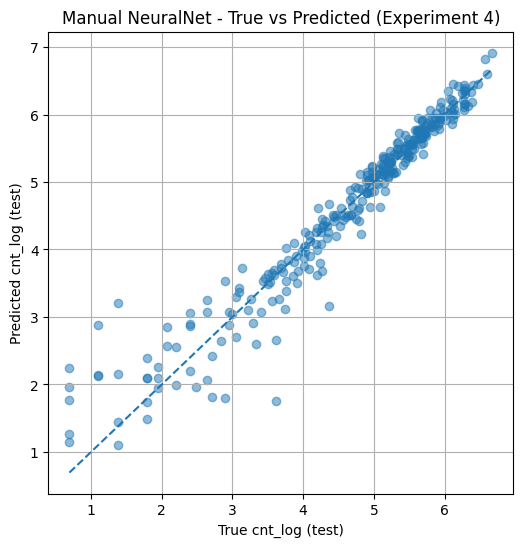

In [ ]:

# Scatter plot: true vs predicted on TEST set


# Predictions in scaled space
y_test_pred_scaled = predict_batch(best_model, X_test_np)

# Back to original target scale
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted cnt_log (test)")
plt.title(f"Manual NeuralNet - True vs Predicted (Experiment {chosen_experiment})")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")  # ideal y = x line
plt.grid(True)
plt.show()


## Summary of manual BP experiments

In this notebook we:

- Loaded the encoded Bike Sharing dataset (`hours_encoded.csv`).
- Selected `cnt_log` as the regression target.
- Sampled 1500 patterns and split them into:
  - 80% for training + validation,
  - 20% for testing.
- Scaled both the input features and the target variable.
- Defined several neural network configurations for the manual BP model
  (different number of hidden units, activation functions, learning rate, momentum, epochs).
- For each configuration we trained the model and computed:
  - MSE, MAE and MAPE on the 80% (train+validation),
  - MSE, MAE and MAPE on the 20% test set.
- Collected the results in a comparison table and selected one experiment
  as the **best manual BP configuration** according to its performance on the test set.

The selected configuration (for example, experiment 2 with `[61, 40, 15, 1]` and `tanh`)
will be used later to compare:

- Manual BP vs Multiple Linear Regression (MLR),
- Manual BP vs PyTorch neural network

in the next notebook: **A1_3_MLR_and_PyTorch_Comparison.ipynb**.
